# Conflict in Lebanon

This notebook visualizes conflict and fatalities in Lebanon from October 7th 2023 to October 10th 2024. 

In [1]:
%load_ext autoreload
%autoreload 2

import geopandas as gpd

from datetime import datetime

import bokeh
from bokeh.models import Tabs, TabPanel
from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
from bokeh.plotting import show, output_notebook

from acled_conflict_analysis import visuals
from acled_conflict_analysis import analysis as analysis
from acled_conflict_analysis import extraction

import os

In [3]:
# import acled_conflict

## Overview

Conflict causes the reversal of short term and long term economic growth {cite}`le2022economic`. Within this analysis, we extract, and visualize the trend of conflict events and fatalities associated with conflict events in the Lebanon from 2012 to 2024. 


## Data

### Armed Conflict Location & Event Data

The Armed Conflict Location & Event Data Project (ACLED) is a disaggregated data collection, analysis, and crisis mapping project. ACLED collects information on the dates, actors, locations, fatalities, and types of all reported political violence and protest events around the world. Access to this data is via a contract between the World bank and ACLED and can be extracted by any World Bank employee upon registering for an API key. 

ACLED data is available for every day since 2016. The data is released with the exact latitude and longitude coordinates of the reported conflict event. The data is collected from four main types of sources - traditional media, reports, local partner data and new media (targeted and verified). ACLED researchers systematically cover thousands of distinct sources in over 75 languages. Sourcing lists are carefully curated and monitored to maintain accurate coverage. More about the methodology can be found in their [codebook](https://acleddata.com/knowledge-base/codebook/#sources-and-information-sourcing).

Every ACLED event is based on at least one source. The source names or acronyms are noted in the ‘Source’ column. With the exception of certain local sources that wish to remain anonymous, the ‘Source’ column details are sufficient to retrace the sources that have been used to record an event. All sources listed have contributed information to the event. Researchers often find multiple reports confirming details about an event; when multiple sources report on the same information, the most thorough, reliable, and recent report is cited. The ACLED team corrects some of their past entries as they get new information about the reported conflict. 

Data prior to 2016 is not available for this specific country. The Data Lab team reached out to the ACLED team to understand why this is currently the case. 

ACLED data contains 6 main types of conflict events - protests, riots, strategic developments, violence against civilians, battles and explosions/remote violence. 


## Methodology and Implementation

ACLED data are analysed and aggregated to admin levels gathered from [HdX](https://data.humdata.org/). The number of fatalities and conflicts are then shown by different event types and different admin regions. 

Following this, the data were mapped using both open source tools and Tableau. 

**You can find the processed files in the [SharePoint folder](https://worldbankgroup.sharepoint.com/teams/DevelopmentDataPartnershipCommunity-WBGroup/Shared%20Documents/Forms/AllItems.aspx?ga=1&id=%2Fteams%2FDevelopmentDataPartnershipCommunity%2DWBGroup%2FShared%20Documents%2FProjects%2FData%20Lab%2FLebanon%20Economic%20Analytics%2FData%2Fconflicts%2Facled&viewid=80cdadb3%2D8bb3%2D47ae%2D8b18%2Dc1dd89c373c5)**

## Findings

Write the raw data to a file and read from it. This is to avoid running the API again in case of having to restart kernel/continue analysis

In [2]:
countries_of_interest = ["Lebanon"]
START_DATE = "2012-01-01"
END_DATE = "2024-11-03"

In [3]:
lebanon_adm0 = gpd.read_file(
    "../../data/shapefiles/lbn_adm_cdr_20200810/lbn_admbnda_adm0_cdr_20200810.shp"
)
lebanon_adm1 = gpd.read_file(
    "../../data/shapefiles/lbn_adm_cdr_20200810/lbn_admbnda_adm1_cdr_20200810.shp"
)
lebanon_adm2 = gpd.read_file(
    "../../data/shapefiles/lbn_adm_cdr_20200810/lbn_admbnda_adm2_cdr_20200810.shp"
)
lebanon_adm3 = gpd.read_file(
    "../../data/shapefiles/lbn_adm_cdr_20200810/lbn_admbnda_adm3_cdr_20200810.shp"
)

In [5]:
data = extraction.acled_api(
    email_address=os.environ.get("ACLED_EMAIL"),
    access_key=os.environ.get("ACLED_KEY"),
    countries=countries_of_interest,
    start_date=START_DATE,
    end_date=END_DATE,
)

c:\WBG\Anaconda3\envs\data-goods\Lib\site-packages\urllib3\connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.acleddata.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [6]:
analysis.data_type_conversion(data)

In [7]:
data = data[data['event_date']>'2023-10-07']

In [8]:
acled_adm0_annual = analysis.get_acled_by_admin(
    lebanon_adm0, data, columns=["admin0Name"], freq="YS"
)
conflict_monthly = analysis.get_acled_by_group(
    data, columns=["country", "latitude", "longitude"], freq="MS"
)
acled_adm0 = analysis.get_acled_by_admin(
    lebanon_adm0, data, columns=["admin0Name"], freq="MS"
)

In [9]:
# events_dict = {'protests':{datetime(2022, 9,16):'Mahsa Amini\nDeath',

#                datetime(2019,2,13):'Khash-Zahedan\nsuicide bombing',
#                datetime(2022,10,26):'Shah Cherag\nMassacre',
#                datetime(2019, 11,15):'Bloody Aban',
#                datetime(2024, 1,3):'Kerman\nBombings',
#                datetime(2020, 1,3): 'Qasem Soleimani\nAssassination'
#                #datetime(2022, 10,5): 'West Azerbaijan\nEarthquake',
#                }}

### Annual and Monthly Conflict Trends

In [10]:
# output_file("bokeh_plot.html")
output_notebook()
bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)

tabs = []
titles = [
    "Number of annual fatalities at a national level",
    "Number of annual conflict events at a national level",
]

for idx, type in enumerate(["nrFatalities", "nrEvents"]):
    tabs.append(
        TabPanel(
            child=visuals.get_line_plot(
                acled_adm0_annual,
                f"{titles[idx]}",
                f"Source: ACLED. Accessed {datetime.today().date().isoformat()}",
                subtitle="",
                category="admin0Name",
                measure=type,
                # events_dict = events_dict
            ),
            title=type.capitalize(),
        )
    )

tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)

Loading BokehJS ...

In [11]:
# output_file("bokeh_plot.html")
output_notebook()
bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)

tabs = []
titles = [
    "Number of monthly fatalities at a national level",
    "Number of monthly conflict events at a national level",
]

for idx, type in enumerate(["nrFatalities", "nrEvents"]):
    tabs.append(
        TabPanel(
            child=visuals.get_line_plot(
                acled_adm0,
                f"{titles[idx]}",
                f"Source: ACLED. Accessed {datetime.today().date().isoformat()}",
                subtitle="",
                category="admin0Name",
                measure=type,
                # events_dict = events_dict
            ),
            title=type.capitalize(),
        )
    )

tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)

Loading BokehJS ...

In [12]:
visuals.get_animated_map(conflict_monthly, "Lebanon", 50, "nrFatalities", "P1M")

In [13]:
sizeCategoryLabels = {
    5: "Less than 25",
    50: "Less than 50",
    200: "More than 50",
}

def get_size_category(item):
    if item < 25:
        return 5
    elif item <= 50:
        return 50
    elif item > 50:
        return 200

gdf = analysis.convert_to_gdf(conflict_monthly)


gdf['sizeCategory'] = gdf['nrFatalities'].apply(get_size_category)

beirut = gpd.read_file('../../data/shapefiles/lbn_beirut_adm4_mapaction_pcoded/lbn_beirut_adm4_MapAction_Pcoded.shp')

gdf_beirut = gdf.sjoin(beirut)

In [14]:
from matplotlib.colors import LinearSegmentedColormap

# Define the color gradient segments
colors = [(0.0, "#FFD2C1"), (0.5, "#E36359"), (1.0, "#A62C2B")]

# Create the colormap using LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list("custom_colormap", colors)

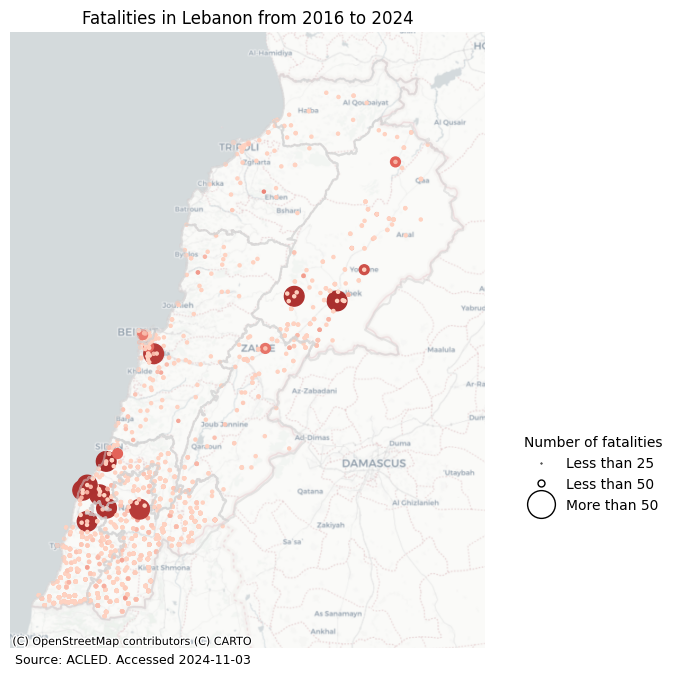

In [16]:
import matplotlib.pyplot as plt
import contextily as ctx

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(10, 8))

# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# country = world[world['name'] == 'Lebanon']


gdf.plot(
    column="nrFatalities",cmap=cmap, ax=ax, markersize="sizeCategory", marker="o"
)
lebanon_adm1.boundary.plot(ax=ax, color="lightgrey", alpha=0.5, zorder=1)
ax.set_title("Fatalities in Lebanon from 2016 to 2024")

sizes = gdf[gdf['event_date']>'2023-10-08'].sort_values(by="sizeCategory")["sizeCategory"].unique()

#country.plot(ax=ax, color='none', edgecolor='black')
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)


handles = []
for size in sizes:
    (handle,) = ax.plot(
        [],
        [],
        marker="o",
        markersize=size / 10,
        linestyle="",
        label=sizeCategoryLabels[size],
        markerfacecolor="white",
        markeredgecolor="black",
    )
    handles.append(handle)
ax.legend(
    handles=handles,
    title="Number of fatalities",
    loc="lower right",
    frameon=False,
    bbox_to_anchor=(1.4, 0.2),
)

plt.figtext(0.28, 0.09, f'Source: ACLED. Accessed {datetime.today().date().isoformat()}', ha="left", fontsize=9, color="black")


ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xticks([])
ax.set_yticks([])

plt.savefig('../../docs/images/fatalities_nov2024.png', dpi=800, bbox_inches='tight');


In [17]:
acled_adm1_annual = analysis.get_acled_by_admin(
    lebanon_adm1, data, columns=["admin0Name", "admin1Name"], freq="YS"
)
acled_adm1 = analysis.get_acled_by_admin(
    lebanon_adm1, data, columns=["admin0Name", "admin1Name"], freq="MS"
)

worst_fatalities_all_time = list(
    acled_adm1_annual.groupby(["admin1Name"])[["nrEvents", "nrFatalities"]]
    .sum()
    .reset_index()
    .sort_values(by="nrFatalities", ascending=False)
    .head(5)["admin1Name"]
)

### Conflict by Province

In [18]:
output_notebook()
bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)

tabs = []
titles = ["Number of fatalities", "Number of conflict events"]

for idx, type in enumerate(["nrFatalities", "nrEvents"]):
    tabs.append(
        TabPanel(
            child=visuals.get_line_plot(
                acled_adm1[acled_adm1["admin1Name"].isin(worst_fatalities_all_time)],
                f"{titles[idx]} by province",
                f"Source: ACLED. Accessed {datetime.today().date().isoformat()}",
                subtitle="",
                category="admin1Name",
                measure=type,
            ),
            title=type.capitalize(),
        )
    )

tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)

Loading BokehJS ...

In [19]:
acled_adm1_annual.groupby(["admin1Name"])[
    ["nrEvents", "nrFatalities"]
].sum().reset_index().sort_values(by="nrFatalities", ascending=False).head(
    5
).reset_index(drop=True)

,admin1Name,nrEvents,nrFatalities
0,El Nabatieh,7184,923
1,South,4033,906
2,Baalbek-El Hermel,520,395
3,Mount Lebanon,311,240
4,Bekaa,188,105


In [20]:
acled_events = analysis.get_acled_by_admin(lebanon_adm0, data, columns=["event_type"])
acled_events_daily = analysis.get_acled_by_admin(
    lebanon_adm0, data, columns=["event_type"], freq="D"
)

### Conflict by Event Type

In [21]:
output_notebook()
bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)

tabs = []
conflict_event_type = analysis.get_acled_by_group(
    data, columns=["country", "event_type"], freq="MS"
)

titles = ["Number of fatalities", "Number of conflict events"]

for idx, type in enumerate(["nrFatalities", "nrEvents"]):
    tabs.append(
        TabPanel(
            child=visuals.get_line_plot(
                conflict_event_type,
                f"{titles[idx]} by event type",
                f"Source: ACLED. Accessed {datetime.today().date().isoformat()}",
                subtitle="",
                category="event_type",
                measure=type,
            ),
            title=type.capitalize(),
        )
    )

tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)

Loading BokehJS ...

In [22]:
from bokeh.plotting import show, output_notebook
import bokeh
from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
from bokeh.models import Tabs, TabPanel

output_notebook()

bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)

tabs = []
measure_names = {
    "nrEvents": "Number of Conflict Events",
    "nrFatalities": "Number of Fatalities",
}
measure_colors = {"nrEvents": "#4E79A7", "nrFatalities": "#F28E2B"}
# acled_adm0 = get_acled_by_admin(syria_adm2_crs, acled, columns = ['ADM2_EN', 'ADM1_EN'])
for category_type in list(conflict_event_type["event_type"].unique()):
    tabs.append(
        TabPanel(
            child=visuals.get_bar_chart(
                conflict_event_type,
                f"Number of {category_type}",
                f"Source: ACLED. Accessed date {datetime.today().date().isoformat()}",
                subtitle="",
                category="event_type",
                measure="nrEvents",
                color_code=measure_colors["nrEvents"],
                category_value=category_type,
                # events_dict=events_dict
            ),
            title=category_type.title(),
        )
    )

tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)

Loading BokehJS ...

**What were the explosions about?**

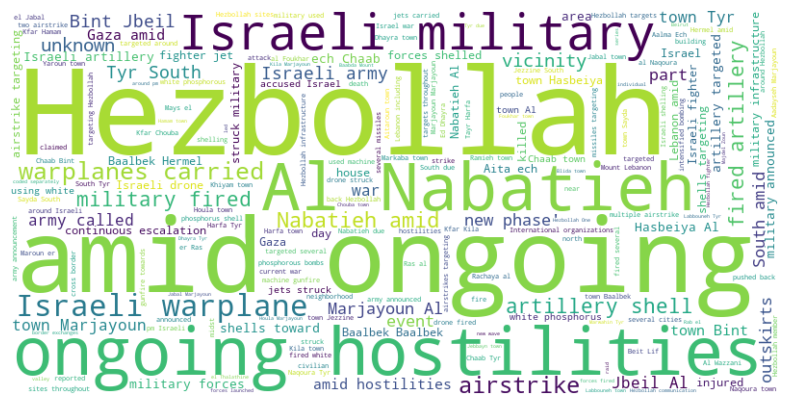

In [23]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt


def generate_word_cloud_from_column(df, column_name, custom_stopwords):
    # Combine all the text in the specified column into a single string
    text = " ".join(note for note in df[column_name])

    stopwords = set(STOPWORDS)
    if custom_stopwords:
        stopwords.update(custom_stopwords)

    # Generate the word cloud
    # Generate the word cloud, excluding the stopwords
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color="white",
        stopwords=stopwords,  # Pass the stopwords set here
    ).generate(text)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")  # Hide the axes
    plt.show()


month_names = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December",
]

custom_stopwords = month_names + [
    "protest",
    "protested",
    "great",
    "front",
    "rally",
    "District Tehran",
    "Tehran",
    "group",
    "District",
    "held",
    "Iran",
    "casualties",
]
# Generate and display the word cloud from the 'notes' column
generate_word_cloud_from_column(
    data[(data["event_type"] == "Explosions/Remote violence")],
    "notes",
    custom_stopwords,
)

In [24]:
acled_events_daily = analysis.get_acled_by_group(data, columns=["event_type"], freq="D")
acled_events_without_protests = analysis.get_acled_by_group(
    data[data["event_type"] != "Protests"], columns=["country"], freq="D"
)

In [25]:
acled_events_daily.to_csv(
    "../../data/conflict/acled_events_daily_20120101_20241103.csv"
)
acled_events_without_protests.to_csv(
    "../../data/conflict/acled_events_without_protests_20120101_20241103.csv"
)

## Limitations

ACLED is a crowdsourced dataset. Despite it being verified through local sources, it does not capture all the of the conflicts that occur in the region. 

## References


{cite:empty}`ROMAN2018113`

```{bibliography}
:filter: docname in docnames
:style: plain
